> # 원문
>> http://cs231n.github.io/convolutional-networks/

# Convolutional Neural Network

 합성곱 신경망(Convolutional Neural Network)은 일반 신경망과 매우 유사하다. CNN은 학습 가능한 가중치(Weight)와 편향(Bias)로 구성되어 있다. 각 뉴런은 입력을 받아 내적 연산(Dot Product)을 한 뒤 선택에 따라, 비선형(Non-Linear) 연산을 한다.

 전체 네트워크는 일반 신경망과 마찬가지로 미분 가능한 하나의 스코어 함수(Score Function)을 갖게 된다. (가장 앞에서 원본 이미지(Raw Image)를 읽고, 가장 뒤에서 각 클래스에 대한 점수를 출력). 또한 ConvNet은 마지막 레이어에 (SVM/Softmax와 같은) 손실 함수(Loss Function)을 가지며, 우리가 일반 신경망을 학습시킬 때 사용하던 각종 기법들을 동일하게 적용할 수 있다.

 ConvNet과 일반 신경망의 차이점은, ConvNet 설계자는 입력 데이터가 이미지라는 가정 덕분에 이미지 데이터가 갖는 특성들을 인코딩 할 수 있다. 이러한 아키텍쳐는 포워드 함수(Forward Function)을 더욱 효과적으로 구현할 수 있고 네트워크를 학습시키는데 필요한 매개 변수(Parameter)의 수를 크게 줄일 수 있게 해준다.

## 아키텍쳐 개요

 이전 내용에서 보았듯이 신경망은 입력받은 벡터를 일련의 히든 레이어(Hidden Layer) 를 통해 변형(Transform) 시킨다. 각 히든 레이어는 뉴런들로 이뤄져 있으며, 각 뉴런은 앞쪽 레이어(Previous layer)의 모든 뉴런과 연결되어 있다(Fully Connected). 같은 레이어 내에 있는 뉴런들 끼리는 연결이 존재하지 않고 서로 독립적이다. 마지막 Fully-Connected 레이어는 출력 레이어라고 불리며, 분류 문제에서 클래스 점수(Class Score)를 나타낸다.

 일반 신경망은 이미지를 다루기에 적절하지 않다. CIFAR-10 데이터의 경우 각 이미지가 32 x 32 x 3 (가로,세로 32, 3개 컬러 채널)로 이뤄져 있어서 첫 번째 히든 레이어 내의 하나의 뉴런의 경우 32 x 32 x 3 = 3072개의 가중치가 필요하지만, 더 큰 이미지를 사용할 경우에는 같은 구조를 이용하는 것이 불가능하다.

 예를 들어 200 x 200 x 3의 크기를 가진 이미지는 같은 뉴런에 대해 200 x 200 x 3 = 120,000개의 가중치를 필요로 하기 때문이다. 더욱이, 이런 뉴런이 레이어 내에 여러개 존재하므로 모수의 개수가 크게 증가하게 된다. 이와 같이 Fully-Connectivity는 심한 낭비이며 많은 수의 모수는 곧 오버피팅(Overfitting)으로 귀결된다.

 ConvNet은 입력이 이미지로 이뤄져 있다는 특징을 살려 좀 더 합리적인 방향으로 아키텍쳐를 구성할 수 있다. 특히 일반 신경망과 달리, ConvNet의 레이어들은 가로, 세로, 깊이의 3개 차원을 갖게 된다. 여기에서 말하는 깊이란 전체 신경망의 깊이가 아니라 활성 볼륨(Activation Volume) 에서의 3번째 차원을 말한다.
 
 예를 들어 CIFAR-10 이미지는 32 x 32 x 3(가로, 세로, 깊이)의 차원을 갖는 입력 활성 볼륨(Activation Volume)이라고 볼 수 있다. 조만간 보겠지만, 하나의 레이어에 위치한 뉴런들은 일반 신경망과는 달리 앞 레이어의 전체 뉴런이 아닌 일부에만 연결이 되어 있다. ConvNet 아키텍쳐는 전체 이미지를 클래스 점수들로 이뤄진 하나의 벡터로 만들어주기 때문에 마지막 출력 레이어는 1 x 1 x 10(10은 CIFAR-10 데이터의 클래스 개수)의 차원을 가지게 된다. 이에 대한 그럼은 아래와 같다:

![neural_net2](./resources/imgs/neural_net2.jpeg)
  
$$일반\ 3-Layer\ 신경망$$


## ConvNet을 이루는 레이어들

위에서 다룬 것과 같이, ConvNet의 각 레이어는 미분 가능한 변환 함수를 통해 하나의 액티베이션 볼륨을 또다른 액티베이션 볼륨으로 변환 (transform) 시킨다. ConvNet 아키텍쳐에서는 크게 컨볼루셔널 레이어, 풀링 레이어, Fully-connected 레이어라는 3개 종류의 레이어가 사용된다. 전체 ConvNet 아키텍쳐는 이 3 종류의 레이어들을 쌓아 만들어진다.

### CIFAR-10 데이터를 다루기 위한 간단한 ConvNet

$$[INPUT] - ([CONV] - [RELU] - [POOL])* - [FC]$$

1. INPUT[32x32x3]: 입력으로 이미지가 가로32, 세로32, 그리고 RGB 채널
<br><br>
2. CONV[32x32x12]: 레이어는 입력 이미지의 일부 영역과 연결되어 있으며, 이 연결된 영역과 자신의 가중치의 내적 연산(Dot Product)을 계산
<br><br>
3. RELU[32x32x12]: 레이어는 액티베이션 함수(Activation Function)로 max(0, x)를 각 요소에 적용(이 레이어는 볼륨의 크기를 변화시키지 않음)
<br><br>
4. POOL[16x16x12]: 레이어는 (가로,세로) 차원에 대해 다운샘플링 (downsampling)을 수행해 와 같이 줄어든 볼륨을 출력한다.
<br><br>
5. FC[1x1x10]: (Fully-Connected) 레이어는 클래스 점수들을 계산해 결과를 출력, 10개의 숫자들은 10개 카테고리에 대한 각 클래스의 점수에 해당. 레이어의 이름에서 유추 가능하듯, 이 레이어는 이전 볼륨의 모든 요소와 연결 됨

이와 같이, ConvNet은 픽셀 값으로 이뤄진 원본 이미지를 각 레이어를 거치며 클래스 점수로 변환(Transform) 시킨다.

한 가지 기억할 것은, 어떤 레이어는 모수(Parameter)를 갖지만 어떤 레이어는 모수(Parameter)를 갖지 않는다는 것이다.

특히 [CONV]/[FC] 레이어들은 단순히 입력 볼륨만이 아니라 가중치(Weight)와 편향(Bias)을 포함하는 활성 함수(Activation Function)이다.

반면 [RELU]/[POOL] 레이어들은 고정된 함수이다. [CONV]/[FC] 레이어의 모수(Parameter)들은 각 이미지에 대한 클래스 점수가 해당 이미지의 레이블과 같아지도록 경사 하강법(Gradient Descent)으로 학습된다.

## 요약

* ConvNet 아키텍쳐는 여러 레이어를 통해 입력 이미지를 클래스 점수로 변환
<br><br>
* ConvNet은 [CONV]/[RELU]/[POOL]/[FC] 레이어 등으로 구성
<br><br>
* 각 레이어는 3차원의 입력 볼륨을 미분 가능 함수를 통해 3차원 출력 볼륨으로 변환
<br><br>
* 모수(parameter)를 갖는 레이어도 있고, 그렇지 않은 레이어도 있다
 - 모수 포함　: [FC]/[CONV]
 - 모수 미포함: [RELU]/[POOL]
 <br><br>
* 초모수(hyper-parameter)를 갖는 레이어도 있고 그렇지 않은 레이어도 있다
 - 초모수 포함　: [FC]/[CONV]/[POOL]
 - 초모수 미포함: [RELU]
 
<div style="text-align: right"> 초모수(hyper-parameter): 모수(paramter)의 모수(paramter)</div>

### Convolutional Layer

 합성곱 레이어는 ConvNet을 이루는 핵심 요소이다. 합성곱 레이어의 출력은 3차원으로 정렬된 뉴런들로 해석될 수 있다.

 이제부터는 뉴런들의 **연결성(Connectivity)**, **공간상의 배치** 그리고 **모수 공유(parameter sharing)**에 대한 설명이다.

### 개요

합성곱 레이어의 모수(parameter)들은 일련의 학습가능한 필터들로 이뤄져 있다. 각 필터는 가로/세로 차원으로는 작지만 깊이(Depth) 차원으로는 전체 깊이를 아우른다.

 다음 레이어로 **전달(Forward Pass)**할 때에는 각 필터를 입력 볼륨의 가로/세로 차원으로 슬라이딩(*정확히는 Convolve*) 시키며 2차원의 **활성화 맵(Activation Map)을 생성**한다.
 
 필터를 입력 위로 슬라이딩 시킬 때, 필터와 입력의 요소들 사이의 **내적 연산(Dot Product)**이 이뤄진다.
 
 직관적으로 설명하면, 이 신경망은 입력의 특정 위치의 특정 패턴에 대해 반응하는 **활성 필터(Activate Filter)**를 학습한다.
 
 이런 **활성화 맵(Activation Map)**을 깊이(Depth) 차원을 따라 쌓은 것이 곧 출력 볼륨이 된다.
 
 그러므로 출력 볼륨의 각 요소들은 입력의 작은 영역만을 취급하고, 같은 활성화 맵 내의 뉴런들은, 같은 필터를 적용한 결과이므로, 같은 모수들을 공유한다.

### 로컬 연결성 (Local connectivity)

이미지와 같은 고차원 입력을 다룰 때에는, 현재 레이어의 한 뉴런을 이전 볼륨의 모든 뉴런들과 연결하는 것이 비 실용적이다. 대신에 우리는 레이어의 각 뉴런을 입력 볼륨의 로컬한 영역(local region)에만 연결할 것이다. 이 영역은 리셉티브 필드 (receptive field)라고 불리는 초모수 (hyperparameter) 이다. 깊이 차원 측면에서는 항상 입력 볼륨의 총 깊이를 다룬다 (가로/세로는 작은 영역을 보지만 깊이는 전체를 본다는 뜻). 공간적 차원 (가로/세로)와 깊이 차원을 다루는 방식이 다르다는 걸 기억하자.

---

예제 1. 예를 들어 입력 볼륨의 크기가 CIFAR-10의 RGB 이미지와 같이 [32x32x3]일 때,  만약 리셉티브 필드의 크기가 5x5라면, CONV 레이어의 각 뉴런은 입력 볼륨의 [5x5x3] 크기의 영역에 가중치 (weight)를 가하게 된다 (총 5x5x3=75 개 가중치).
입력 볼륨 (RGB 이미지)의 깊이가 3이므로 마지막 숫자가 3이 된다는 것을 기억하자.

예제 2. 입력 볼륨의 크기가 [16x16x20]이라고 하자. 3x3 크기의 리셉티브 필드를 사용하면 CONV 레이어의 각 뉴런은 입력 볼륨과 3x3x20=180 개의 연결을 갖게 된다. 이번에도 입력 볼륨의 깊이가 20이므로 마지막 숫자가 20이 된다는 것을 기억하자.

---

![neuron_model](./resources/imgs/neuron_model.jpeg)
  
입력의 일부 영역에만 연결된다는 점을 제외하고는, 이전 신경망에서 다뤄지던 뉴런들과 똑같이 내적 연산과 비선형 함수로 이뤄진다.

### 공간적 배치

지금까지는 컨볼루션 레이어의 한 뉴런과 입력 볼륨의 연결에 대해 알아보았다. 그러나 아직 출력 볼륨에 얼마나 많은 뉴런들이 있는지, 그리고 그 뉴런들이 어떤식으로 배치되는지는 다루지 않았다.

**3개의 초모수(hyperparameter)들이 출력 볼륨의 크기를 결정**하게 된다. 그 3개 요소는 바로 **깊이(Depth)**, **보폭(Stride), 제로 패딩(Zero-Padding)** 이다.

### 합성곱(Convolution)

아래는 컨볼루션 레이어를 설명하는 그림이다.

3차원 볼륨은 시각화하기 힘드므로 각 행마다 Depth Slice를 하나씩 배치했다.

각 볼륨은 입력 볼륨(파란색), 가중치 볼륨(빨간색), 출력 볼륨(녹색)으로 이뤄진다. 

* 입력크기: **W1=5, H1=5, D1=3**
* 파라미터: **K=2, F=3, S=2, P=1**

즉, 2개의 [3×33×3] 크기의 필터(Filter, Kernel)가 각각 **stride 2**로 적용된다. 

그러므로 출력 볼륨의 spatial(크기, 가로/세로)는 **(5 - 3 + 2) / 2 + 1 = 3**이다. 

제로 패딩 **P=1** 이 적용되어 입력 볼륨의 가장자리가 모두 0으로 되어있다.

하이라이트 표시된 입력(파란색)과 필터(빨간색)의 같은 위치의 원소값들이 
**elementwise로 곱해진 뒤 하나로 더해**지고 **bias가 더해**지는걸 볼 수 있다.

![conv1](./resources/imgs/conv1.gif)

![conv2](./resources/imgs/conv2.gif)


### Backpropagation

컨볼루션 연산의 backward pass 역시 컨볼루션 연산이다(가로/세로가 뒤집어진 필터를 사용한다는 차이점이 존재), 간단한 1차원 예제를 가지고 쉽게 확인해볼 수 있다.

### 풀링 레이어 (Pooling Layer)

 ConvNet 구조 내에 컨볼루션 레이어들 중간중간에 주기적으로 풀링 레이어를 넣는 것이 일반적이다. 풀링 레이어가 하는 일은 네트워크의 파라미터의 개수나 연산량을 줄이기 위해 사이즈를 줄이는 것이다.

 이는 **오버피팅을 조절하는 효과**도 가지고 있다. 풀링 레이어는 MAX 연산을 각 Depth Slice에 대해 독립적으로 적용해 크기를 줄인다.

 사이즈 2x2와 stride 2의 Max Pooling 기법이 풀링 레이어에 가장 많이 사용된다. 이 경우 MAX 연산은 4개 숫자(같은 depth slice 내의 2x2 영역) 중 최대값을 선택하고, Depth 차원은 변하지 않는다. 
 
 각 Depth Slice를 가로/세로축을 따라 1/2로 downsampling해 3/4의 액티베이션은 버리게 된다.
 
풀링 레이어의 특징들은 일반적으로 아래와 같다

1. W1×H1×D1 사이즈의 입력을 받는다
<br><br>
2. 3가지 hyperparameter를 필요로 한다.
 - Spatial extent F
 - Stride S
 <br><br>
3. W2×H2×D2 사이즈의 볼륨을 만든다
$$
W_2 = \frac{(W_1 − F)}{S} + 1 \\
H_2 = \frac{(H_1 − F)}{S} + 1 \\
D2=D1
$$
<br><br>
4. 입력에 대해 항상 같은 연산을 하므로 파라미터는 따로 존재하지 않는다
5. 풀링 레이어에는 보통 제로 패딩을 하지 않는다

일반적으로 실전에서는 두 종류의 max 풀링 레이어만 널리 쓰인다.

하나는 overlapping 풀링이라고도 불리는 F=3, S=2이고 
하나는 더 자주 쓰이는 F=2,S=2이다.

큰 리셉티브 필드에 대해서 풀링을 하면 보통 너무 많은 정보를 버리게 된다.

### 일반적인 Pooling

1. Max Pooling
2. Average Pooling
3. L2-Norm Pooling

등 다른 연산으로 풀링이 가능하며, Average Pooling은 Max Pooling보다 성능이 떨어져 거의 사용되지 않는 추세다.

### 최근 추세

1. Fractional Max-Pooling
<br>2x2보다 더 작은 필터들로 풀링하는 방식. 1x1, 1x2, 2x1, 2x2 크기의 필터들을 임의로 조합해 풀링한다. 매 forward pass마다 grid들이 랜덤하게 생성되고, 테스트 때에는 여러 grid들의 예측 점수들의 평균치를 사용하게 된다.
<br><br>
2. Striving for Simplicity
<br>The All Convolutional Net 라는 논문은 컨볼루션 레이어만 반복하며 풀링 레이어를 사용하지 않는 방식을 제안한다. Representation의 크기를 줄이기 위해 가끔씩 큰 stride를 가진 컨볼루션 레이어를 사용한다.
<br>풀링 레이어가 보통 Representation의 크기를 심하게 줄이기 때문에 (이런 효과는 작은 데이터셋에서만 오버피팅 방지 효과 등으로 인해 도움이 됨), 최근 추세는 점점 풀링 레이어를 사용하지 않는 쪽으로 발전하고 있다.

### Normalization 레이어

실제 두뇌의 억제 메커니즘 구현 등을 위해 많은 종류의 normalization 레이어들이 제안되었다.

그러나 이런 레이어들이 실제로 주는 효과가 별로 없다는 것이 알려지면서 최근에는 거의 사용되지 않고 있다.

### Fully Connected 레이어

Fully Connected 레이어 내의 뉴런들은 이전 레이어의 모든 Activation들과 연결된다.

그러므로 Fully Connected 레이어의 Activation y = XW + b 형태로 행렬곱과 덧셈을 통해 구할 수 있다.

### 레이어 크기 결정 패턴

ConvNet 구조의 크기를 결정하는 법칙(수학적으로 증명된 법칙은 아니고 실험적으로 좋은 법칙):

**INPUT 레이어** (이미지 포함)는 여러번 2로 나눌 수 있어야 한다. 흔히 사용되는 숫자들은 32 (CIFAR-10 데이터), 64, 96 (STL-10), 224 (많이 쓰이는 ImageNet ConvNet), 384, 512 등이 있다.

**CONV 레이어**는 (3x3 또는 최대 5x5의)작은 필터들과 S=1의 stride를 사용하며, 결정적으로 입력과 출력의 spatial 크기 (가로/세로)가 달라지지 않도록 입력 볼륨에 제로 패딩을 해 줘야 한다.

즉, F=3이라면, P=1로 제로 패딩을 해 주면 입력의 spatial 사이즈를 그대로 유지하게 된다. 만약 F=5라면 P=2를 사용하게 된다. 

일반적으로 F에 대해서 P=(F−1)/2를 사용하면 입력의 크기가 그대로 유지된다. 만약 7x7과 같이 큰 필터를 사용하는 경우에는 보통 이미지와 바로 연결된 첫 번째 CONV 레이어에만 사용한다.

**POOL 레이어**는 Spatial 차원에 대한 **다운샘플링**을 위해 사용된다.

가장 일반적인 세팅은 2x2의 리셉티브 필드(**F=2**)를 가진 **max 풀링**이다.

이 경우 **입력의 3/4의 활성 값이 버려진다**(가로/세로에 대해 각각 절반으로 다운샘플링 하므로).

또 다른 약간 덜 사용되는 세팅은 3x3 리셉티브 필드에 stride를 2로 놓는 것이다.

Max 풀링에 3보다 큰 리셉티브 필드를 가지는 경우는 너무 많은 정보를 버리게 되므로 거의 사용되지 않는다. 많은 정보 손실은 곧 성능 하락으로 이어진다.

모든 CONV 레이어는 입력의 Spatial 크기를 그대로 유지시키고, POOL 레이어만 Spatial 차원의 다운샘플링을 책임지게 된다.

또다른 대안은 CONV 레이어에서 1보다 큰 stride를 사용하거나 제로 패딩 주지 않는 것이다. 이 경우에는 전체 ConvNet이 잘 동작하도록 각 레이어의 입력 볼륨들을 잘 살펴봐야 한다.

*왜 CONV 레이어에 stride 1을 사용할까?* 보통 작은 stride가 더 잘 동작한다. 뿐만 아니라, 위에서 언급한 것과 같이 stirde를 1로 놓으면 모든 spatial 다운샘플링을 POOL 레이어에 맡기게 되고 CONV 레이어는 입력 볼륨의 깊이만 변화시키게 된다.

*왜 패딩을 사용할까?* 앞에서 본 것과 같이 CONV 레이어를 통과하면서 spatial 크기를 그대로 유지하게 해준다는 점 외에도, 패딩을 쓰면 성능도 향상된다. 만약 제로 패딩을 하지 않고 valid convolution (패딩을 하지 않은 convolution)을 한다면 볼륨의 크기는 CONV 레이어를 거칠 때마다 줄어들게 되고, 가장자리의 정보들이 빠르게 사라진다.


## 유명 ConvNet

필드에서 사용되는 몇몇 ConvNet들은 별명을 갖고 있다.

### LeNet
최초의 성공적인 ConvNet 애플리케이션들은 1990년대에 Yann LeCun이 만들었다. 그 중에서도 zip 코드나 숫자를 읽는 LeNet 아키텍쳐가 가장 유명하다.

### AlexNet
컴퓨터 비전 분야에서 ConvNet을 유명하게 만든 것은 Alex Krizhevsky, Ilya Sutskever, Geoff Hinton이 만든 AlexNet이다.

AlexNet은 ImageNet ILSVRC challenge 2012에 출전해 2등을 큰 차이로 제치고 1등을 했다 (top 5 에러율 16%, 2등은 26%).

아키텍쳐는 LeNet과 기본적으로 유사지만, 더 깊고 크다. 또한 (과거에는 하나의 CONV 레이어 이후에 바로 POOL 레이어를 쌓은 것과 달리) 여러 개의 CONV 레이어들이 쌓여 있다.

### ZF Net
ILSVRC 2013년의 승자는 Matthew Zeiler와 Rob Fergus가 만들었다. 저자들의 이름을 따 ZFNet이라고 불린다. AlexNet에서 중간 CONV 레이어 크기를 조정하는 등 하이퍼파라미터들을 수정해 만들었다.

### GoogLeNet
ILSVRC 2014의 승자는 Szegedy et al. 이 구글에서 만들었다. 이 모델의 가장 큰 기여는 파라미터의 개수를 엄청나게 줄여주는 Inception module을 제안한 것이다 (4M, AlexNet의 경우 60M).

뿐만 아니라, ConvNet 마지막에 FC 레이어 대신 Average 풀링을 사용해 별로 중요하지 않아 보이는 파라미터들을 많이 줄이게 된다.

### VGGNet
ILSVRC 2014에서 2등을 한 네트워크는 Karen Simonyan과 Andrew Zisserman이 만든 VGGNet이라고 불리우는 모델이다. 이 모델의 가장 큰 기여는 네트워크의 깊이가 좋은 성능에 있어 매우 중요한 요소라는 것을 보여준 것이다.

이들이 제안한 여러 개 모델 중 가장 좋은 것은 16개의 CONV/FC 레이어로 이뤄지며, 모든 컨볼루션은 3x3, 모든 풀링은 2x2만으로 이뤄져 있다. 비록 GoogLeNet보다 이미지 분류 성능은 약간 낮지만, 여러 Transfer Learning 과제에서 더 좋은 성능을 보인다는 것이 나중에 밝혀졌다.

그래서 VGGNet은 최근에 이미지 feature 추출을 위해 가장 많이 사용되고 있다. Caffe를 사용하면 Pretrained model을 받아 바로 사용하는 것도 가능하다. VGGNet의 단점은, 매우 많은 메모리를 사용하며 (140M) 많은 연산을 한다는 것이다.

### ResNet
Kaiming He et al.이 만든 Residual Network가 ILSVRC 2015에서 우승을 차지했다.

Skip connection이라는 특이한 구조를 사용하며 **Batch Normalizatoin**을 많이 사용했다는 특징이 있다.

이 아키텍쳐는 또한 마지막 부분에서 FC 레이어를 사용하지 않는다. Kaiming의 발표자료 (video, slides)나 Torch로 구현된 최근 실험들 들도 확인할 수 있다.

## ConvNet 관련 고려사항들

ConvNet을 만들 때 일어나는 가장 큰 병목 현상은 메모리 병목이다. 최신 GPU들은 3GB, 4GB, 6GB, 가장 좋은 GPU들의 경우 12GB의 메모리를 내장하고 있다.

1. 중간 단계의 볼륨 크기: 매 레이어에서 발생하는 액티베이션들과 그에 상응하는 그라디언트 (액티베이션과 같은 크기)의 개수이다. 보통 대부분의 액티베이션들은 ConvNet의 앞쪽 레이어들에서 발생된다 (예: 첫 번째 CONV 레이어). 이 값들은 backpropagation에 필요하기 때문에 계속 메모리에 두고 있어야 한다. 학습이 아닌 테스트에만 ConvNet을 사용할 때는 현재 처리 중인 레이어의 액티베이션 값을 제외한 앞쪽 액티베이션들은 버리는 방식으로 구현할 수 있다.
<br><br>
2. 파라미터 크기: 신경망이 갖고 있는 파라미터의 개수이며, backpropagation을 위한 각 파라미터의 그라디언트, 그리고 최적화에 momentum, Adagrad, RMSProp 등을 사용한다면 이와 관련된 파라미터들도 캐싱해 놓아야 한다. 그러므로 파라미터 저장 공간은 기본적으로 (파라미터 개수의)3배 정도 더 필요하다.
<br><br>
3. 모든 ConvNet 구현체는 이미지 데이터 배치 등을 위한 기타 용도의 메모리를 유지해야 한다.

일단 액티베이션, 그라디언트, 기타용도에 필요한 값들의 개수를 예상했다면, GB 스케일로 바꿔야 한다.

예측한 개수에 (floating point가 4바이트, double precision의 경우 8바이트)를 곱한 후, 1024로 여러 번 나눠 KB, MB, GB로 바꾼다.

만약 신경망의 크기가 너무 크다면 대부분의 메모리가 액티베이션에 사용되므로, 배치 크기를 줄여 가용 메모리에 맞게 만들어야 한다.

In [2]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

(1, 3, 3, 1)


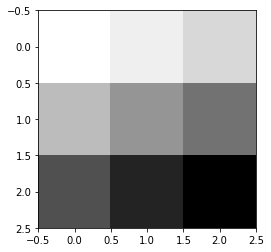

In [3]:
sess = tf.InteractiveSession()
image = np.array([[[[1],[2],[3]],
                   [[4],[5],[6]], 
                   [[7],[8],[9]]]], dtype=np.float32)
print(image.shape)
plt.imshow(image.reshape(3,3), cmap='Greys')

# (1, 3, 3, 1) => (이미지 개수, 3행, 3열, 하나의 값)

## 1 filter (2,2,1,1) with padding: VALID, SAME

image.shape (1, 3, 3, 1)
weight.shape (2, 2, 1, 1)
conv2d_img.shape (1, 3, 3, 1)
[[ 12.  16.   9.]
 [ 24.  28.  15.]
 [ 15.  17.   9.]]


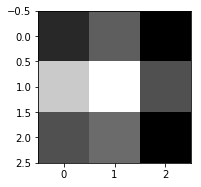

In [10]:
# print("imag:\n", image)
print("image.shape", image.shape)
weight = tf.constant([[[[1.]],[[1.]]],
                      [[[1.]],[[1.]]]])
print("weight.shape", weight.shape)
#conv2d = tf.nn.conv2d(image, weight, strides=[1, 1, 1, 1], padding='VALID')
conv2d = tf.nn.conv2d(image, weight, strides=[1, 1, 1, 1], padding='SAME')
conv2d_img = conv2d.eval()
print("conv2d_img.shape", conv2d_img.shape)
conv2d_img = np.swapaxes(conv2d_img, 0, 3)
for i, one_img in enumerate(conv2d_img):
    # reshaped_img = one_img.reshape(2, 2)
    reshaped_img = one_img.reshape(3, 3)
    print(reshaped_img)
    plt.subplot(1, 2, i+1), plt.imshow(reshaped_img, cmap='gray')

## 3 Filters (2, 2, 1, 3)

image.shape (1, 3, 3, 1)
weight.shape (2, 2, 1, 3)
conv2d_img.shape (1, 3, 3, 3)
[[ 12.  16.   9.]
 [ 24.  28.  15.]
 [ 15.  17.   9.]]
[[ 120.  160.   90.]
 [ 240.  280.  150.]
 [ 150.  170.   90.]]
[[-12. -16.  -9.]
 [-24. -28. -15.]
 [-15. -17.  -9.]]


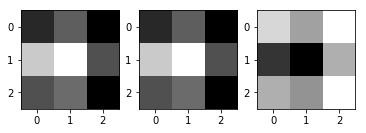

In [11]:
# print("imag:\n", image)
print("image.shape", image.shape)

weight = tf.constant([[[[1.,10.,-1.]],[[1.,10.,-1.]]],
                      [[[1.,10.,-1.]],[[1.,10.,-1.]]]])
print("weight.shape", weight.shape)
conv2d = tf.nn.conv2d(image, weight, strides=[1, 1, 1, 1], padding='SAME')
conv2d_img = conv2d.eval()
print("conv2d_img.shape", conv2d_img.shape)
conv2d_img = np.swapaxes(conv2d_img, 0, 3)
for i, one_img in enumerate(conv2d_img):
    print(one_img.reshape(3,3))
    plt.subplot(1,3,i+1), plt.imshow(one_img.reshape(3,3), cmap='gray')

## MAX POOLING with padding: VALID, SAME

In [16]:
image = np.array([[[[4],[3]],
                    [[2],[1]]]], dtype=np.float32)
# pool = tf.nn.max_pool(image, ksize=[1, 2, 2, 1], strides=[1, 1, 1, 1], padding='VALID')
pool = tf.nn.mbax_pool(image, ksize=[1, 2, 2, 1], strides=[1, 1, 1, 1], padding='SAME')
print(pool.shape)
print(pool.eval())

(1, 2, 2, 1)
[[[[ 4.]
   [ 3.]]

  [[ 2.]
   [ 1.]]]]


## MNIST with CNN

In [17]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
# Check out https://www.tensorflow.org/get_started/mnist/beginners for
# more information about the mnist dataset

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


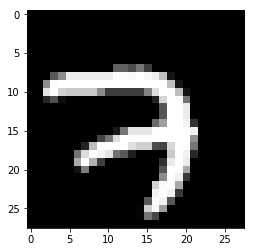

In [31]:
img = mnist.train.images[0].reshape(28,28)
plt.imshow(img, cmap='gray')

In [27]:
lbl = mnist.train.labels[0]
print(lbl)

[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


In [32]:
sess = tf.InteractiveSession()

print(img.shape)
img = img.reshape(-1, 28, 28, 1)
W1 = tf.Variable(tf.random_normal([3, 3, 1, 5], stddev=0.01)) # [3 x 3], 단일 원소 필터, 5개
conv2d = tf.nn.conv2d(img, W1, strides=[1, 2, 2, 1], padding='SAME') # 세로 보폭 2, 가로 보폭 2
print(conv2d)

(28, 28)
Tensor("Conv2D_11:0", shape=(1, 14, 14, 5), dtype=float32)


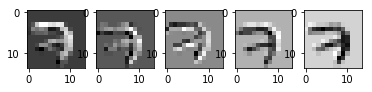

In [35]:
sess.run(tf.global_variables_initializer())
conv2d_img = conv2d.eval()                 # Tensorflow 실행
conv2d_img = np.swapaxes(conv2d_img, 0, 3) # 0th <=> 3rd 축 변경
for i, one_img in enumerate(conv2d_img):   # 각 필터 별 컨볼루션 결과
    plt.subplot(1, 5, i+1) # 1 ~ 5번의 subplot 중 (i + 1)번째 plot을 사용
    plt.imshow(one_img.reshape(14,14), cmap='gray')

## MNIST with MAX POOLING

Tensor("MaxPool_5:0", shape=(1, 7, 7, 5), dtype=float32)


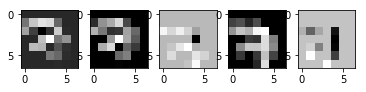

In [38]:
pool = tf.nn.max_pool(conv2d, 
                      ksize=[1, 2, 2, 1], 
                      strides=[1, 2, 2, 1], 
                      padding='SAME')
print(pool)

sess.run(tf.global_variables_initializer())
pool_img = pool.eval()
pool_img = np.swapaxes(pool_img, 0, 3)

for i, one_img in enumerate(pool_img):
    plt.subplot(1, 5, i+1)
    plt.imshow(one_img.reshape(7, 7), cmap='gray')

## MNIST & CNN Example

In [39]:
import tensorflow as tf
import random
# import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data

tf.set_random_seed(777)  # reproducibility

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
# Check out https://www.tensorflow.org/get_started/mnist/beginners for
# more information about the mnist dataset

# hyper parameters
learning_rate = 0.001
training_epochs = 15
batch_size = 100

# input place holders
X = tf.placeholder(tf.float32, [None, 784])
X_img = tf.reshape(X, [-1, 28, 28, 1])   # img 28x28x1 (black/white)
Y = tf.placeholder(tf.float32, [None, 10])

# L1 ImgIn shape=(?, 28, 28, 1)
W1 = tf.Variable(tf.random_normal([3, 3, 1, 32], stddev=0.01))
#    Conv     -> (?, 28, 28, 32)
#    Pool     -> (?, 14, 14, 32)
L1 = tf.nn.conv2d(X_img, W1, strides=[1, 1, 1, 1], padding='SAME')
L1 = tf.nn.relu(L1)
L1 = tf.nn.max_pool(L1, ksize=[1, 2, 2, 1],
                    strides=[1, 2, 2, 1], padding='SAME')
'''
Tensor("Conv2D:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("Relu:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("MaxPool:0", shape=(?, 14, 14, 32), dtype=float32)
'''

# L2 ImgIn shape=(?, 14, 14, 32)
W2 = tf.Variable(tf.random_normal([3, 3, 32, 64], stddev=0.01))
#    Conv      ->(?, 14, 14, 64)
#    Pool      ->(?, 7, 7, 64)
L2 = tf.nn.conv2d(L1, W2, strides=[1, 1, 1, 1], padding='SAME')
L2 = tf.nn.relu(L2)
L2 = tf.nn.max_pool(L2, ksize=[1, 2, 2, 1],
                    strides=[1, 2, 2, 1], padding='SAME')
L2_flat = tf.reshape(L2, [-1, 7 * 7 * 64])
'''
Tensor("Conv2D_1:0", shape=(?, 14, 14, 64), dtype=float32)
Tensor("Relu_1:0", shape=(?, 14, 14, 64), dtype=float32)
Tensor("MaxPool_1:0", shape=(?, 7, 7, 64), dtype=float32)
Tensor("Reshape_1:0", shape=(?, 3136), dtype=float32)
'''

# Final FC 7x7x64 inputs -> 10 outputs
W3 = tf.get_variable("W3", shape=[7 * 7 * 64, 10],
                     initializer=tf.contrib.layers.xavier_initializer())
b = tf.Variable(tf.random_normal([10]))
logits = tf.matmul(L2_flat, W3) + b

# define cost/loss & optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# initialize
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# train my model
print('Learning started. It takes sometime.')
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = int(mnist.train.num_examples / batch_size)

    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        feed_dict = {X: batch_xs, Y: batch_ys}
        c, _ = sess.run([cost, optimizer], feed_dict=feed_dict)
        avg_cost += c / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning Finished!')

# Test model and check accuracy
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print('Accuracy:', sess.run(accuracy, feed_dict={
      X: mnist.test.images, Y: mnist.test.labels}))

# Get one and predict
r = random.randint(0, mnist.test.num_examples - 1)
print("Label: ", sess.run(tf.argmax(mnist.test.labels[r:r + 1], 1)))
print("Prediction: ", sess.run(
    tf.argmax(logits, 1), feed_dict={X: mnist.test.images[r:r + 1]}))

# plt.imshow(mnist.test.images[r:r + 1].
#           reshape(28, 28), cmap='Greys', interpolation='nearest')
# plt.show()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Learning started. It takes sometime.
Epoch: 0001 cost = 0.322131441
Epoch: 0002 cost = 0.086149222
Epoch: 0003 cost = 0.063875355
Epoch: 0004 cost = 0.052874141
Epoch: 0005 cost = 0.045416309
Epoch: 0006 cost = 0.038921274
Epoch: 0007 cost = 0.033458253
Epoch: 0008 cost = 0.028985214
Epoch: 0009 cost = 0.025437944
Epoch: 0010 cost = 0.021899389
Epoch: 0011 cost = 0.019174992
Epoch: 0012 cost = 0.016516186
Epoch: 0013 cost = 0.014708604
Epoch: 0014 cost = 0.013128898
Epoch: 0015 cost = 0.011366158
Learning Finished!
Accuracy: 0.9891
Label:  [8]
Prediction:  [8]
